# **Projet Green AI : Robot de Tri de Déchets sur Plage**

#### Auteurs : Paul-Adrien LU-YEN-TUNG, Nassim LOUDIYI, Gabriel MACCIONE, Cyrille MALONGO, Julien MARONNE

## **Introduction**

Ce notebook présente l’ensemble du pipeline développé pour entraîner et évaluer des modèles de deep learning appliqués à la classification d’images de déchets dans un contexte d’environnement simulé.  
L’objectif principal est d’explorer différentes architectures — notamment **MobileNetV2** et **ResNet18** — afin d’optimiser la performance tout en mesurant l’impact environnemental de leur entraînement grâce à **CodeCarbon**.

Pour renforcer la robustesse des modèles face à des variations de terrain, un **dataset artificiel avec fond de sable** a été généré à partir du dataset d’origine. Ce travail inclut :

- la création d’un pipeline automatique de remplacement d’arrière-plan (GrabCut + fond sable),
- la génération du dataset `dataset_sand`,
- la mise en place d’un split **train / val / test** cohérent,
- l’entraînement complet de plusieurs modèles avec suivi de l’empreinte carbone,
- la comparaison des impacts environnementaux (exprimés en mg/ng de CO₂),
- ainsi que l’intégration des modèles entraînés dans un **environnement de simulation Pygame** via un robot virtuel.

Ce notebook constitue donc une démonstration complète et reproductible, reliant :

- **Préparation des données**  
- **Entraînement des modèles**  
- **Analyse écologique**  
- **Visualisation des résultats**  
- **Intégration dans une application interactive**  

Il sert de base à la fois à l’analyse scientifique et au développement logiciel dans le cadre du projet de classification intelligente et durable des déchets.

In [1]:
import os
import shutil
import random
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2

# PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, datasets, models
from torch.utils.data import DataLoader, random_split

print("PyTorch :", torch.__version__)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device :", device)

PROJECT_DIR = os.getcwd()
print("Project dir :", PROJECT_DIR)

PyTorch : 2.9.1+cpu
Device : cpu
Project dir : c:\Users\paull\OneDrive - De Vinci\Bureau\Cours esilv\A4\Semestre 1\Green AI\Green_AI_project\green-AI-2\src


**Création du dataset**

In [2]:
# ------------------------------
# 1) Définition des dossiers
# ------------------------------

# Répertoire du projet = dossier parent de src/
PROJECT_DIR = os.path.dirname(os.getcwd())

# Dossier contenant les datasets
DATA_DIR = os.path.join(PROJECT_DIR, "dataset")

# Dataset original (images réelles)
DATASET_ORIG = os.path.join(DATA_DIR, "RealWaste")

# Dossier vide où seront stockées les images avec fond sable
DATASET_SAND = os.path.join(PROJECT_DIR, "dataset_sand")

# Dossier contenant ton image de sable (ex : sand/sand.jpg)
ASSET_DIR = os.path.join(PROJECT_DIR, "assets", "sand")


# Création du dossier dataset_sand uniquement (il doit être vide au début)
os.makedirs(DATASET_SAND, exist_ok=True)

print("📁 Dataset original :", DATASET_ORIG)
print("📁 Dataset sable BG (vide) :", DATASET_SAND)
print("📁 Dossier image de sable :", ASSET_DIR)

sand_image_path = None
for fname in os.listdir(ASSET_DIR):
    if fname.lower().endswith((".jpg", ".jpeg", ".png")):
        sand_image_path = os.path.join(ASSET_DIR, fname)
        break

if sand_image_path is None:
    raise FileNotFoundError("Aucune image (.jpg/.jpeg/.png) trouvée dans le dossier 'asset'.")

print("Image de sable utilisée :", sand_image_path)

📁 Dataset original : c:\Users\paull\OneDrive - De Vinci\Bureau\Cours esilv\A4\Semestre 1\Green AI\Green_AI_project\green-AI-2\dataset\RealWaste
📁 Dataset sable BG (vide) : c:\Users\paull\OneDrive - De Vinci\Bureau\Cours esilv\A4\Semestre 1\Green AI\Green_AI_project\green-AI-2\dataset_sand
📁 Dossier image de sable : c:\Users\paull\OneDrive - De Vinci\Bureau\Cours esilv\A4\Semestre 1\Green AI\Green_AI_project\green-AI-2\assets\sand
Image de sable utilisée : c:\Users\paull\OneDrive - De Vinci\Bureau\Cours esilv\A4\Semestre 1\Green AI\Green_AI_project\green-AI-2\assets\sand\sand1.jpg


**Aperçu du dataset original**

Classes détectées : ['Glass', 'Metal', 'Natural', 'Paper', 'Plastic']


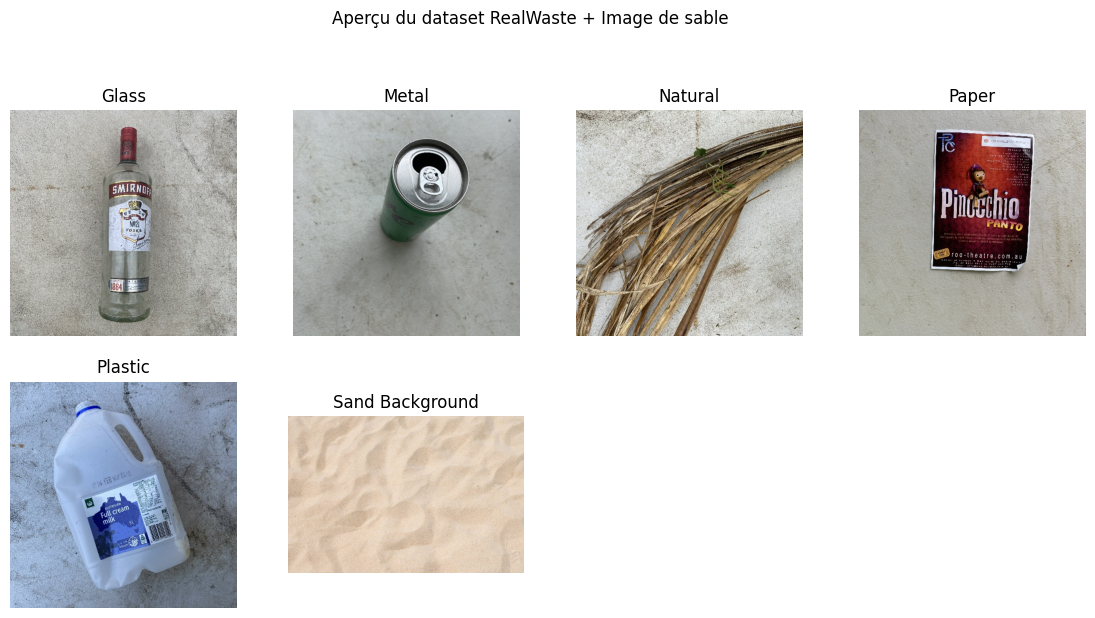

In [41]:
import os
import matplotlib.pyplot as plt

# ------------------------------
# 1) Récupération des classes du dataset original
# ------------------------------

classes = sorted([
    c for c in os.listdir(DATASET_ORIG)
    if os.path.isdir(os.path.join(DATASET_ORIG, c))
])

print("Classes détectées :", classes)

# ------------------------------
# 2) Visualisation : une image par classe + image de sable
# ------------------------------

plt.figure(figsize=(14, 10))

# Nombre total d’images affichées (classes + 1 image de sable)
total_images = min(len(classes), 9)

for i, cls in enumerate(classes[:total_images]):
    cls_dir = os.path.join(DATASET_ORIG, cls)

    # Récupère la première image du dossier
    img_name = next((f for f in os.listdir(cls_dir)
                     if f.lower().endswith((".png", ".jpg", ".jpeg"))), None)

    if img_name is None:
        continue

    img_path = os.path.join(cls_dir, img_name)
    img = plt.imread(img_path)

    plt.subplot(3, 4, i + 1)
    plt.imshow(img)
    plt.title(cls)
    plt.axis("off")

# ------------------------------
# 3) Ajouter l’image de sable en dernier
# ------------------------------

sand_img = plt.imread(sand_image_path)

plt.subplot(3, 4, total_images + 1)
plt.imshow(sand_img)
plt.title("Sand Background")
plt.axis("off")

plt.suptitle("Aperçu du dataset RealWaste + Image de sable")
plt.show()


**Remplacer le fond des images en fond de sable**

Afin de permettre au robot de s'entraîner à détecter au mieux des déchets sur la plage, nous avons remplacé le fond de toutes les images en fond de sable.

In [42]:
sand_images = [
    f for f in os.listdir(ASSET_DIR)
    if f.lower().endswith((".jpg", ".jpeg", ".png"))
]
assert len(sand_images) > 0, "Le dossier Sand doit contenir des images."

def replace_background_with_sand(img_path, save_path):
    img = cv2.imread(img_path)
    if img is None:
        return

    h, w = img.shape[:2]
    mask = np.zeros((h, w), np.uint8)

    rect = (10, 10, w-20, h-20)

    bgModel = np.zeros((1,65), np.float64)
    fgModel = np.zeros((1,65), np.float64)

    try:
        cv2.grabCut(img, mask, rect, bgModel, fgModel, 5, cv2.GC_INIT_WITH_RECT)
    except:
        cv2.imwrite(save_path, img)
        return

    mask2 = np.where((mask==2)|(mask==0), 0, 1).astype("uint8")

    sand_choice = random.choice(sand_images)
    sand = cv2.imread(os.path.join(ASSET_DIR, sand_choice))
    sand = cv2.resize(sand, (w, h))

    result = sand.copy()
    result[mask2==1] = img[mask2==1]

    cv2.imwrite(save_path, result)


In [43]:
for cls in tqdm(classes, desc="Fond sable"):
    src_dir = os.path.join(DATASET_ORIG, cls)
    dst_dir = os.path.join(DATASET_SAND, cls)
    os.makedirs(dst_dir, exist_ok=True)

    for img_name in os.listdir(src_dir):
        if not img_name.lower().endswith((".jpg",".jpeg",".png")):
            continue

        src_path = os.path.join(src_dir, img_name)
        dst_path = os.path.join(dst_dir, img_name)

        if not os.path.exists(dst_path):
            replace_background_with_sand(src_path, dst_path)

print("Dataset RealWaste_sand généré ✔️")


Fond sable: 100%|██████████| 5/5 [00:01<00:00,  2.69it/s]

Dataset RealWaste_sand généré ✔️


Nombre total d'images disponibles dans dataset_sand : 3067


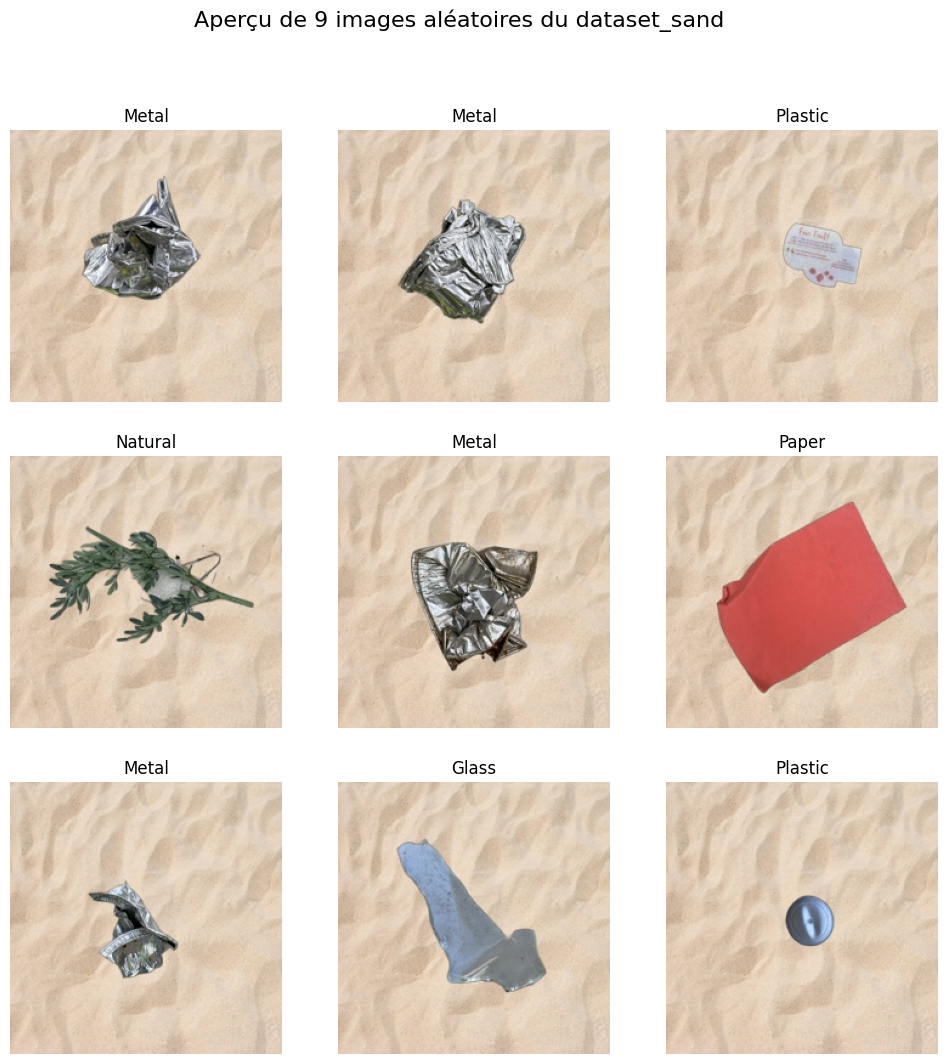

In [44]:
import os
import random
import matplotlib.pyplot as plt
from PIL import Image

# ------------------------------
# 1) Récupération de toutes les images dans dataset_sand
# ------------------------------

all_sand_images = []

for cls in os.listdir(DATASET_SAND):
    cls_dir = os.path.join(DATASET_SAND, cls)
    if not os.path.isdir(cls_dir):
        continue

    imgs = [
        os.path.join(cls_dir, f)
        for f in os.listdir(cls_dir)
        if f.lower().endswith((".jpg", ".jpeg", ".png"))
    ]
    all_sand_images.extend(imgs)

total = len(all_sand_images)
print(f"Nombre total d'images disponibles dans dataset_sand : {total}")

if total == 0:
    raise ValueError("❌ Aucune image trouvée dans dataset_sand. Vérifie la génération.")

# ------------------------------
# 2) Sélection de 9 images aléatoires (ou moins si dataset plus petit)
# ------------------------------

n = min(9, total)
sample_images = random.sample(all_sand_images, n)

# ------------------------------
# 3) Affichage en grille 3×3 (ou ajustée si moins de 9 images)
# ------------------------------

cols = 3
rows = (n + cols - 1) // cols  # nombre de lignes nécessaires

plt.figure(figsize=(12, 4 * rows))

for i, img_path in enumerate(sample_images):
    img = Image.open(img_path)

    plt.subplot(rows, cols, i + 1)
    plt.imshow(img)
    plt.title(os.path.basename(os.path.dirname(img_path)))  # nom de la classe
    plt.axis("off")

plt.suptitle(f"Aperçu de {n} images aléatoires du dataset_sand", fontsize=16)
plt.show()


**Création du jeu de données train et test**

In [3]:
import os
import shutil
from sklearn.model_selection import train_test_split

# ------------------------------
# 1) Dossiers train / test basés sur dataset_sand
# ------------------------------

TRAIN_DIR = os.path.join(DATA_DIR, "train")
TEST_DIR  = os.path.join(DATA_DIR, "test")

# On repart de zéro pour être sûr que le split correspond bien à dataset_sand
shutil.rmtree(TRAIN_DIR, ignore_errors=True)
shutil.rmtree(TEST_DIR, ignore_errors=True)
os.makedirs(TRAIN_DIR, exist_ok=True)
os.makedirs(TEST_DIR, exist_ok=True)

print("📁 TRAIN_DIR :", TRAIN_DIR)
print("📁 TEST_DIR  :", TEST_DIR)

# ------------------------------
# 2) Classes prises depuis dataset_sand
# ------------------------------

classes = sorted([
    c for c in os.listdir(DATASET_SAND)
    if os.path.isdir(os.path.join(DATASET_SAND, c))
])

print("Classes trouvées dans dataset_sand :", classes)

# ------------------------------
# 3) Split train / test et copie des fichiers
# ------------------------------

test_ratio = 0.2  # 20% test, 80% train

for cls in classes:
    src_dir = os.path.join(DATASET_SAND, cls)
    imgs = [
        f for f in os.listdir(src_dir)
        if f.lower().endswith((".jpg", ".jpeg", ".png"))
    ]

    if len(imgs) == 0:
        print(f"⚠️ Aucun fichier image pour la classe {cls}, ignorée.")
        continue

    train_imgs, test_imgs = train_test_split(
        imgs, test_size=test_ratio, random_state=42
    )

    train_cls_dir = os.path.join(TRAIN_DIR, cls)
    test_cls_dir  = os.path.join(TEST_DIR, cls)
    os.makedirs(train_cls_dir, exist_ok=True)
    os.makedirs(test_cls_dir, exist_ok=True)

    for f in train_imgs:
        shutil.copy2(os.path.join(src_dir, f),
                     os.path.join(train_cls_dir, f))

    for f in test_imgs:
        shutil.copy2(os.path.join(src_dir, f),
                     os.path.join(test_cls_dir, f))

print("✅ Split train/test à partir de dataset_sand terminé.")


📁 TRAIN_DIR : c:\Users\paull\OneDrive - De Vinci\Bureau\Cours esilv\A4\Semestre 1\Green AI\Green_AI_project\green-AI-2\dataset\train
📁 TEST_DIR  : c:\Users\paull\OneDrive - De Vinci\Bureau\Cours esilv\A4\Semestre 1\Green AI\Green_AI_project\green-AI-2\dataset\test
Classes trouvées dans dataset_sand : ['Glass', 'Metal', 'Natural', 'Paper', 'Plastic']
✅ Split train/test à partir de dataset_sand terminé.


Ce prochain bloc configure d’abord la taille des images et la taille de batch, puis définit deux pipelines de transformation :  
un pour l’entraînement, incluant des augmentations simples (flip horizontal, rotation) afin de rendre le modèle plus robuste aux variations naturelles des déchets sur la plage,  
et un pour le test, volontairement plus neutre pour garantir une évaluation fidèle.  
Les images sont redimensionnées, converties en tenseurs et normalisées selon les statistiques d’ImageNet, ce qui est essentiel pour les modèles pré-entraînés comme MobileNetV2.  
Le dataset d’entraînement est ensuite séparé en un ensemble *train* et *validation* afin de suivre la progression réelle du modèle pendant l’apprentissage.  
Les DataLoaders sont créés pour charger efficacement les images par batch, avec mélange aléatoire uniquement sur l’entraînement.  
Enfin, le script affiche la taille de chaque split ainsi que les classes détectées, et déduit automatiquement le nombre total de classes à prédire.

In [4]:
IMG_SIZE = 224
BATCH_SIZE = 32 

train_transform = transforms.Compose([ transforms.Resize((IMG_SIZE, IMG_SIZE)), transforms.RandomHorizontalFlip(), transforms.RandomRotation(20), transforms.ToTensor(), transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225]) ]) 
test_transform = transforms.Compose([ transforms.Resize((IMG_SIZE, IMG_SIZE)), transforms.ToTensor(), transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225]) ]) 

full_train_dataset = datasets.ImageFolder(TRAIN_DIR, transform=train_transform) 

val_size = int(0.2 * len(full_train_dataset)) 
train_size = len(full_train_dataset) - val_size 

train_dataset, val_dataset = random_split(full_train_dataset, [train_size, val_size]) 
test_dataset = datasets.ImageFolder(TEST_DIR, transform=test_transform) 

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True) 
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False) 
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False) 

print("Train:", len(train_dataset)," Val:", len(val_dataset)," Test:", len(test_dataset)) 
print("Classes :", full_train_dataset.classes) 
num_classes = len(full_train_dataset.classes)

Train: 1962  Val: 490  Test: 615
Classes : ['Glass', 'Metal', 'Natural', 'Paper', 'Plastic']


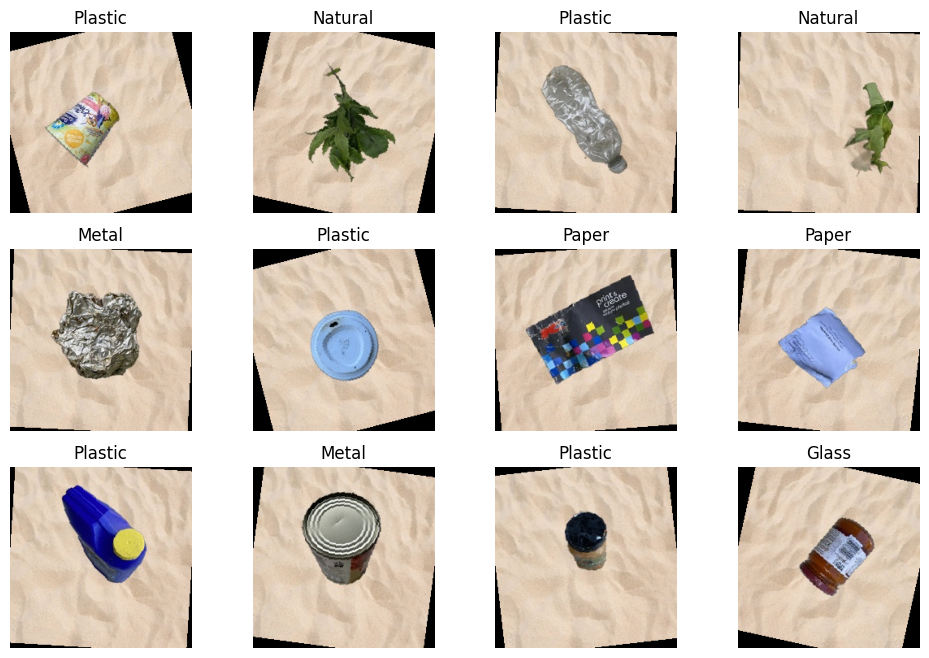

In [47]:
images, labels = next(iter(train_loader))

mean = torch.tensor([0.485,0.456,0.406]).reshape(3,1,1)
std = torch.tensor([0.229,0.224,0.225]).reshape(3,1,1)

plt.figure(figsize=(12,8))
for i in range(12):
    img = images[i] * std + mean
    img = img.permute(1,2,0).numpy()

    plt.subplot(3,4,i+1)
    plt.imshow(np.clip(img,0,1))
    plt.title(full_train_dataset.classes[labels[i]])
    plt.axis("off")

plt.show()


**Création du robot avec un fond de sable**

In [48]:
import cv2
import numpy as np
import os

# Dossier assets
ASSET_DIR = os.path.join("..", "assets", "sand")   # même dossier que ton sand1.jpg
ROBOT_PATH = os.path.join("..", "assets", "robot.png")
OUTPUT_PATH = os.path.join("..", "assets", "robot_sand.png")

# Charge robot (image avec fond blanc)
robot = cv2.imread(ROBOT_PATH)
h, w = robot.shape[:2]

# Mask pour séparer le robot du fond
mask = np.zeros((h, w), np.uint8)
rect = (10, 10, w-20, h-20)

bgModel = np.zeros((1,65), np.float64)
fgModel = np.zeros((1,65), np.float64)

try:
    cv2.grabCut(robot, mask, rect, bgModel, fgModel, 5, cv2.GC_INIT_WITH_RECT)
except:
    print("GrabCut failed")
    exit()

mask2 = np.where((mask==2)|(mask==0), 0, 1).astype("uint8")

# Charger le fond de sable
sand_img_name = [f for f in os.listdir(ASSET_DIR) if f.endswith(('.jpg','.png'))][0]
sand = cv2.imread(os.path.join(ASSET_DIR, sand_img_name))
sand = cv2.resize(sand, (w, h))

# Collage : sable en fond + robot en premier plan
result = sand.copy()
result[mask2 == 1] = robot[mask2 == 1]

cv2.imwrite(OUTPUT_PATH, result)
print("✅ Image robot_sand.png générée :", OUTPUT_PATH)


✅ Image robot_sand.png générée : ..\assets\robot_sand.png


### 1 - **CNN Simple**

In [5]:
class SimpleCNN(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3,32,3,padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(32,64,3,padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(64,128,3,padding=1), nn.ReLU(), nn.MaxPool2d(2),
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128*28*28,256), nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(256, num_classes)
        )

    def forward(self,x):
        x = self.features(x)
        return self.classifier(x)

cnn = SimpleCNN(num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(cnn.parameters(), lr=1e-3)

cnn


SimpleCNN(
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=100352, out_features=256, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.4, inplace=False)
    (4): Linear(in_features=256, out_features=5, bias=True)
  )
)

In [6]:
def train_epoch(model, loader):
    model.train()
    total, correct, loss_sum = 0,0,0

    for X,y in loader:
        X,y = X.to(device), y.to(device)
        optimizer.zero_grad()

        outputs = model(X)
        loss = criterion(outputs,y)
        loss.backward()
        optimizer.step()

        _, preds = torch.max(outputs,1)
        correct += (preds==y).sum().item()
        total += X.size(0)
        loss_sum += loss.item()*X.size(0)

    return loss_sum/total, correct/total

def eval_epoch(model, loader):
    model.eval()
    total, correct, loss_sum = 0,0,0

    with torch.no_grad():
        for X,y in loader:
            X,y = X.to(device), y.to(device)
            outputs = model(X)
            loss = criterion(outputs,y)

            _, preds = torch.max(outputs,1)
            correct += (preds==y).sum().item()
            total += X.size(0)
            loss_sum += loss.item()*X.size(0)

    return loss_sum/total, correct/total


history = {"train_acc":[], "val_acc":[], "train_loss":[], "val_loss":[]}

for epoch in range(1,16):
    tr_loss, tr_acc = train_epoch(cnn, train_loader)
    val_loss, val_acc = eval_epoch(cnn, val_loader)

    history["train_loss"].append(tr_loss)
    history["train_acc"].append(tr_acc)
    history["val_loss"].append(val_loss)
    history["val_acc"].append(val_acc)

    print(f"[{epoch}/15] Train Acc={tr_acc:.3f} | Val Acc={val_acc:.3f}")


[1/15] Train Acc=0.399 | Val Acc=0.545
[2/15] Train Acc=0.533 | Val Acc=0.606
[3/15] Train Acc=0.593 | Val Acc=0.627
[4/15] Train Acc=0.625 | Val Acc=0.645
[5/15] Train Acc=0.668 | Val Acc=0.686
[6/15] Train Acc=0.694 | Val Acc=0.676
[7/15] Train Acc=0.693 | Val Acc=0.657
[8/15] Train Acc=0.716 | Val Acc=0.706
[9/15] Train Acc=0.760 | Val Acc=0.729
[10/15] Train Acc=0.768 | Val Acc=0.724
[11/15] Train Acc=0.758 | Val Acc=0.724
[12/15] Train Acc=0.791 | Val Acc=0.727
[13/15] Train Acc=0.796 | Val Acc=0.749
[14/15] Train Acc=0.805 | Val Acc=0.755
[15/15] Train Acc=0.814 | Val Acc=0.753


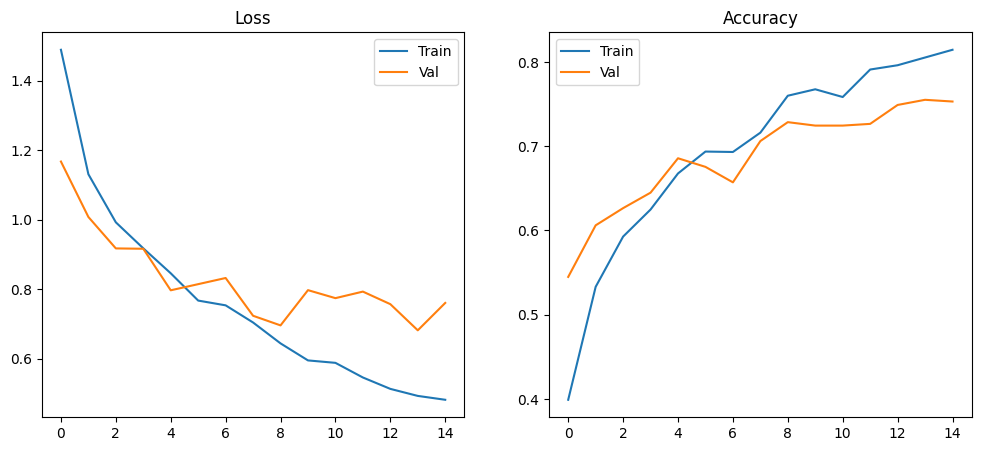

In [7]:
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(history["train_loss"], label="Train")
plt.plot(history["val_loss"], label="Val")
plt.title("Loss"); plt.legend()

plt.subplot(1,2,2)
plt.plot(history["train_acc"], label="Train")
plt.plot(history["val_acc"], label="Val")
plt.title("Accuracy"); plt.legend()

plt.show()


### Analyse des performances du CNN simple

Les courbes montrent une diminution nette de la loss d’entraînement, signe que le modèle parvient à apprendre progressivement les motifs liés aux différents déchets.  
La loss de validation baisse également au début mais devient plus irrégulière ensuite, indiquant que le modèle léger atteint ses limites et peine à généraliser parfaitement.  
Du côté de l’accuracy, l’entraînement progresse de manière régulière tandis que la validation suit une trajectoire similaire mais avec un plafond plus bas.  
L’écart qui se creuse entre les deux courbes traduit un début de surapprentissage : le modèle mémorise mieux ses données d’entraînement qu’il ne s’adapte à de nouvelles images.  
Malgré cela, l’accuracy en validation reste correcte pour un réseau aussi simple, surtout face à un dataset visuellement varié et difficile comme celui des déchets sur plage.  
En résumé, ce CNN apprend efficacement mais montre rapidement ses limites structurelles, ce qui justifie le passage à un modèle plus avancé comme MobileNetV2 pour aller plus loin.


              precision    recall  f1-score   support

       Glass       0.79      0.52      0.63        84
       Metal       0.63      0.81      0.71       158
     Natural       0.87      0.92      0.90        88
       Paper       0.63      0.65      0.64       100
     Plastic       0.67      0.58      0.62       185

    accuracy                           0.69       615
   macro avg       0.72      0.70      0.70       615
weighted avg       0.70      0.69      0.69       615



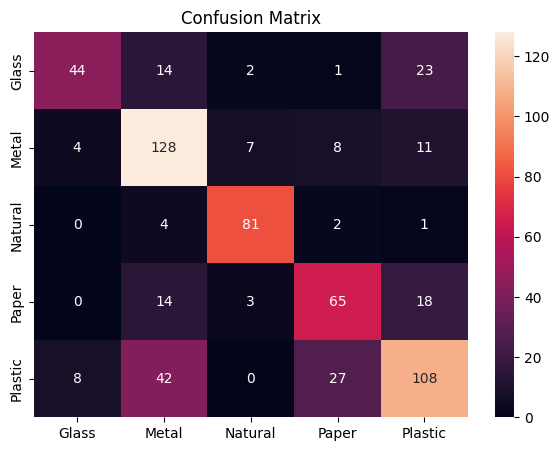

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

cnn.eval()
preds, gts = [], []

with torch.no_grad():
    for X,y in test_loader:
        X = X.to(device)
        outputs = cnn(X)
        _, batch_preds = torch.max(outputs,1)

        preds.extend(batch_preds.cpu().numpy())
        gts.extend(y.numpy())

print(classification_report(gts, preds, target_names=full_train_dataset.classes))

cm = confusion_matrix(gts, preds)

plt.figure(figsize=(7,5))
sns.heatmap(cm, annot=True, fmt="d",
    xticklabels=full_train_dataset.classes,
    yticklabels=full_train_dataset.classes)
plt.title("Confusion Matrix")
plt.show()


In [ ]:
torch.save(cnn.state_dict(), "mon_modele.pth")

### 2 - **Mobile netV2**

Après avoir testé un CNN simple, nous passons maintenant à MobileNetV2, un modèle bien plus performant et optimisé pour la vision sur appareils légers.  
Sa structure en *inverted residuals* et *depthwise separable convolutions* lui permet d’extraire des caractéristiques beaucoup plus riches tout en restant rapide et peu coûteux en calcul.  
Ce choix est particulièrement adapté à notre contexte : détecter la nature des déchets sur une plage, potentiellement en conditions embarquées (robot, drone, mobile…).  
L’entraînement qui suit vise donc à exploiter cette architecture avancée pour améliorer nettement la précision tout en conservant une bonne capacité de généralisation.  
Nous allons préparer MobileNetV2, ajuster sa dernière couche au nombre de classes, puis lancer une phase d’apprentissage complète sur notre dataset sable + déchets.

In [8]:
import torch
import torch.nn as nn
from torchvision import models

def build_mobilenet_v2(num_classes):
    # Charger MobileNetV2 pré-entraîné
    model = models.mobilenet_v2(weights=models.MobileNet_V2_Weights.IMAGENET1K_V1)

    # On récupère la taille de l’entrée du dernier classifier
    in_features = model.classifier[1].in_features

    # Remplacer la dernière couche par notre propre classifier
    model.classifier[1] = nn.Linear(in_features, num_classes)

    return model


In [9]:
mobilenet = build_mobilenet_v2(num_classes).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(mobilenet.parameters(), lr=1e-4)  # lr plus petit !


In [10]:
mobilenet_transform_train = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    ),
])

mobilenet_transform_eval = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    ),
])


In [38]:
num_epochs = 10
history_mob = {
    "train_loss": [], "train_acc": [],
    "val_loss": [], "val_acc": []
}

for epoch in range(num_epochs):
    # TRAIN
    mobilenet.train()
    running_loss, running_corrects, total = 0, 0, 0

    for X, y in train_loader:
        X, y = X.to(device), y.to(device)

        optimizer.zero_grad()
        outputs = mobilenet(X)
        loss = criterion(outputs, y)
        loss.backward()
        optimizer.step()

        _, preds = torch.max(outputs, 1)
        running_loss += loss.item() * X.size(0)
        running_corrects += (preds == y).sum().item()
        total += X.size(0)

    train_loss = running_loss / total
    train_acc = running_corrects / total

    # VAL
    mobilenet.eval()
    val_loss, val_corrects, val_total = 0, 0, 0

    with torch.no_grad():
        for X, y in val_loader:
            X, y = X.to(device), y.to(device)
            outputs = mobilenet(X)
            loss = criterion(outputs, y)

            _, preds = torch.max(outputs, 1)
            val_loss += loss.item() * X.size(0)
            val_corrects += (preds == y).sum().item()
            val_total += X.size(0)

    val_loss = val_loss / val_total
    val_acc = val_corrects / val_total

    history_mob["train_loss"].append(train_loss)
    history_mob["train_acc"].append(train_acc)
    history_mob["val_loss"].append(val_loss)
    history_mob["val_acc"].append(val_acc)

    print(f"[{epoch+1}/{num_epochs}] Train Acc={train_acc:.3f} | Val Acc={val_acc:.3f}")


[1/10] Train Acc=0.636 | Val Acc=0.788
[2/10] Train Acc=0.803 | Val Acc=0.839
[3/10] Train Acc=0.867 | Val Acc=0.833
[4/10] Train Acc=0.902 | Val Acc=0.851
[5/10] Train Acc=0.917 | Val Acc=0.890
[6/10] Train Acc=0.946 | Val Acc=0.880
[7/10] Train Acc=0.952 | Val Acc=0.892
[8/10] Train Acc=0.963 | Val Acc=0.894
[9/10] Train Acc=0.970 | Val Acc=0.900
[10/10] Train Acc=0.965 | Val Acc=0.918


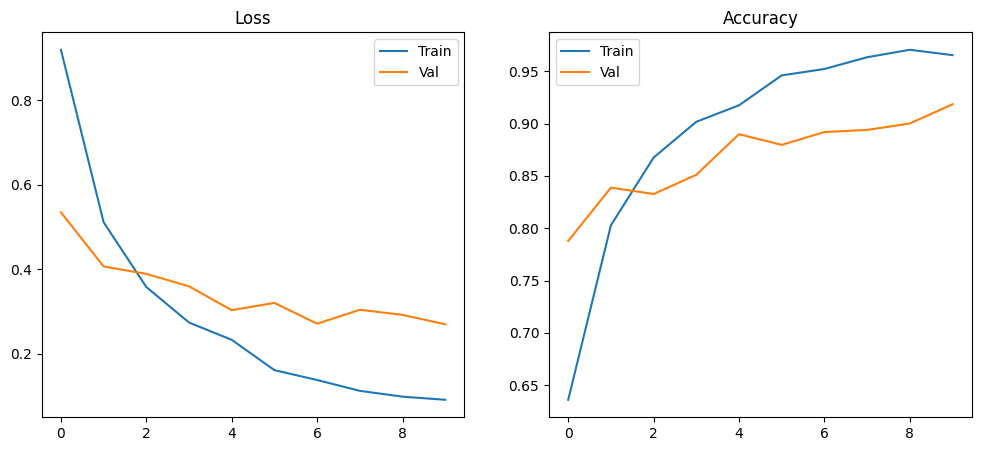

In [51]:
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(history_mob["train_loss"], label="Train")
plt.plot(history_mob["val_loss"], label="Val")
plt.title("Loss"); plt.legend()

plt.subplot(1,2,2)
plt.plot(history_mob["train_acc"], label="Train")
plt.plot(history_mob["val_acc"], label="Val")
plt.title("Accuracy"); plt.legend()

plt.show()


### Analyse des performances de MobileNetV2 

Les courbes montrent que la loss d’entraînement chute très rapidement, ce qui est typique d’un modèle pré-entraîné capable d’extraire immédiatement des features pertinentes.  
La loss de validation suit une trajectoire similaire, sans remontée brutale, signe que MobileNetV2 ne surapprend pas malgré sa puissance.  
Du côté de l’accuracy, le modèle atteint rapidement plus de 90 % en validation, avec une progression régulière et sans oscillations excessives.  
L’écart entre l’accuracy train et val reste raisonnable, ce qui indique une bonne généralisation sur des images de déchets en conditions réalistes (variations de forme, orientation, éclairage).  
Le niveau de performance atteint en seulement quelques epochs confirme l’avantage évident du transfert d’apprentissage face au CNN simple.  
En résumé, MobileNetV2 apprend vite, reste stable et s’adapte très bien au problème de classification des déchets sur plage.


Classification report (MobileNetV2 sur test) :

              precision    recall  f1-score   support

       Glass       0.86      0.87      0.86        84
       Metal       0.82      0.94      0.88       158
     Natural       0.96      1.00      0.98        88
       Paper       0.89      0.92      0.91       100
     Plastic       0.92      0.76      0.83       185

    accuracy                           0.88       615
   macro avg       0.89      0.90      0.89       615
weighted avg       0.89      0.88      0.88       615



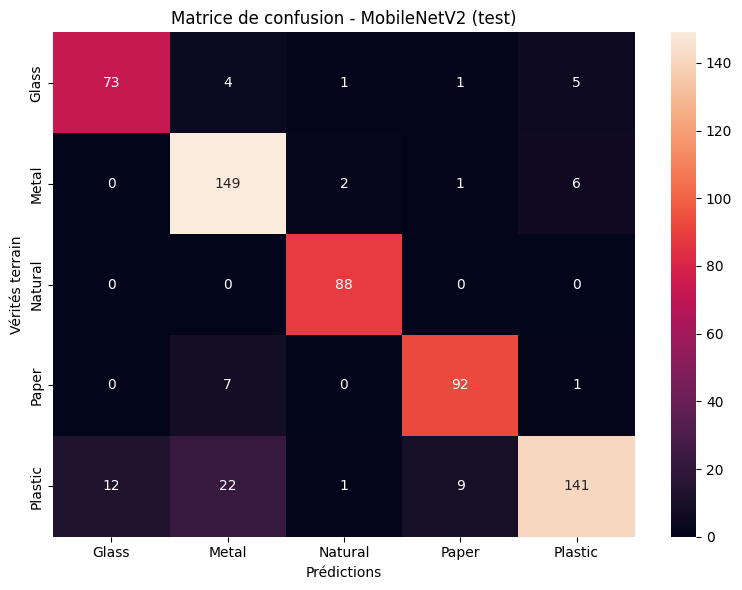

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

mobilenet.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for X, y in test_loader:          # ← ici on utilise bien le dossier test/
        X, y = X.to(device), y.to(device)
        outputs = mobilenet(X)
        _, preds = torch.max(outputs, 1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(y.cpu().numpy())

all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

print("Classification report (MobileNetV2 sur test) :\n")
print(classification_report(all_labels, all_preds, target_names=test_dataset.classes))

cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d",
            xticklabels=test_dataset.classes,
            yticklabels=test_dataset.classes)
plt.xlabel("Prédictions")
plt.ylabel("Vérités terrain")
plt.title("Matrice de confusion - MobileNetV2 (test)")
plt.tight_layout()
plt.show()


In [ ]:
import os
import torch

# --- chemin vers ../models (déjà existant) ---
models_dir = os.path.join("..", "models")

# Vérifier que le dossier existe réellement
if not os.path.isdir(models_dir):
    raise FileNotFoundError(
        f"Le dossier {models_dir} n'existe pas. Vérifie ton arborescence."
    )

model_path = os.path.join(models_dir, "mobilenetv2_trash.pth")

# --- sauvegarde ---
torch.save(mobilenet.state_dict(), model_path)

print(f"Modèle MobileNetV2 sauvegardé dans : {model_path}")


Modèle MobileNetV2 sauvegardé dans : ..\models\mobilenetv2_trash.pth


In [ ]:
from codecarbon import EmissionsTracker

num_epochs = 10  # adapte si tu veux le même nb d'epochs que dans ton notebook

# Fichier CSV de suivi CO₂ pour ce modèle
emissions_file = "emissions_mobilenetv2_sand.csv"
models_dir = os.path.join("..", "models")
tracker = EmissionsTracker(
    output_dir=models_dir,                  # même dossier que tes .pth
    output_file=emissions_file,
    project_name="GreenAI_MobileNetV2_sand",
    on_csv_write="update"
)

tracker.start()

best_val_loss = float("inf")

for epoch in range(num_epochs):
    # --------- TRAIN ---------
    mobilenet.train()
    running_loss, correct, total = 0.0, 0, 0

    for X, y in train_loader:
        X, y = X.to(device), y.to(device)

        optimizer.zero_grad()
        outputs = mobilenet(X)
        loss = criterion(outputs, y)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * X.size(0)
        _, preds = torch.max(outputs, 1)
        correct += (preds == y).sum().item()
        total += y.size(0)

    train_loss = running_loss / total
    train_acc = correct / total

    # --------- VALIDATION ---------
    mobilenet.eval()
    val_loss, val_correct, val_total = 0.0, 0, 0

    with torch.no_grad():
        for X, y in val_loader:
            X, y = X.to(device), y.to(device)
            outputs = mobilenet(X)
            loss = criterion(outputs, y)

            val_loss += loss.item() * X.size(0)
            _, preds = torch.max(outputs, 1)
            val_correct += (preds == y).sum().item()
            val_total += y.size(0)

    val_loss /= val_total
    val_acc = val_correct / val_total

    print(
        f"[MobileNetV2] Epoch {epoch+1}/{num_epochs} | "
        f"Train Loss={train_loss:.4f} Acc={train_acc:.3f} | "
        f"Val Loss={val_loss:.4f} Acc={val_acc:.3f}"
    )

    # on écrit les métriques CO₂ à chaque epoch
    tracker.flush()

tracker.stop()
print(" Suivi CO₂ terminé pour MobileNetV2.")
print(f"Fichier CO₂ généré dans models/ : {emissions_file}")


[codecarbon WARNING @ 00:48:57] Multiple instances of codecarbon are allowed to run at the same time.
[codecarbon INFO @ 00:48:57] [setup] RAM Tracking...
[codecarbon INFO @ 00:48:57] [setup] CPU Tracking...
[codecarbon WARNING @ 00:48:59] We saw that you have a 13th Gen Intel(R) Core(TM) i7-13700H but we don't know it. Please contact us.
[codecarbon WARNING @ 00:48:59] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Windows OS detected: Please install Intel Power Gadget to measure CPU

[codecarbon INFO @ 00:48:59] CPU Model on constant consumption mode: 13th Gen Intel(R) Core(TM) i7-13700H
[codecarbon WARNING @ 00:48:59] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 00:48:59] [setup] GPU Tracking...
[codecarbon INFO @ 00:48:59] Tracking Nvidia GPU via pynvml
[codecarbon INFO @ 00:49:00] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation model
                CPU Track

[MobileNetV2] Epoch 1/10 | Train Loss=0.7095 Acc=0.733 | Val Loss=0.5273 Acc=0.794


[codecarbon INFO @ 00:50:42] Energy consumed for all GPUs : 0.000054 kWh. Total GPU Power : 2.317802440923338 W
[codecarbon INFO @ 00:50:42] 0.001388 kWh of electricity and 0.000000 L of water were used since the beginning.
[codecarbon INFO @ 00:50:46] Energy consumed for RAM : 0.000265 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 00:50:46] Delta energy consumed for CPU with constant : 0.000047 kWh, power : 42.5 W
[codecarbon INFO @ 00:50:46] Energy consumed for All CPU : 0.001127 kWh
[codecarbon INFO @ 00:50:46] Energy consumed for all GPUs : 0.000059 kWh. Total GPU Power : 5.055345848284238 W
[codecarbon INFO @ 00:50:46] 0.001451 kWh of electricity and 0.000000 L of water were used since the beginning.
[codecarbon INFO @ 00:50:46] 0.000803 g.CO2eq/s mean an estimation of 25.33636015468019 kg.CO2eq/year
[codecarbon INFO @ 00:50:47] Energy consumed for RAM : 0.000353 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 00:50:47] Delta energy consumed for CPU with constant : 0.000166 kWh, power : 4

[MobileNetV2] Epoch 2/10 | Train Loss=0.4440 Acc=0.827 | Val Loss=0.4642 Acc=0.810


[codecarbon INFO @ 00:52:19] Energy consumed for all GPUs : 0.000107 kWh. Total GPU Power : 13.478856432343296 W
[codecarbon INFO @ 00:52:19] 0.002708 kWh of electricity and 0.000000 L of water were used since the beginning.
[codecarbon WARNING @ 00:52:19] graceful shutdown. Exceptions:
[codecarbon WARNING @ 00:52:19] <class 'Exception'>
Traceback (most recent call last):
  File "C:\Users\paull\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\codecarbon\core\util.py", line 24, in suppress
    yield
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.13_3.13.2544.0_x64__qbz5n2kfra8p0\Lib\contextlib.py", line 85, in inner
    return func(*args, **kwds)
  File "C:\Users\paull\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\codecarbon\emissions_tracker.py", line 633, in flush
    self._persist_data(
    ~~~~~~~~~~~~~~~~~~^

[MobileNetV2] Epoch 3/10 | Train Loss=0.3266 Acc=0.877 | Val Loss=0.4444 Acc=0.827


[codecarbon INFO @ 00:53:56] Energy consumed for all GPUs : 0.000155 kWh. Total GPU Power : 2.077367179406983 W
[codecarbon INFO @ 00:53:56] 0.004028 kWh of electricity and 0.000000 L of water were used since the beginning.
[codecarbon WARNING @ 00:53:56] graceful shutdown. Exceptions:
[codecarbon WARNING @ 00:53:56] <class 'Exception'>
Traceback (most recent call last):
  File "C:\Users\paull\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\codecarbon\core\util.py", line 24, in suppress
    yield
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.13_3.13.2544.0_x64__qbz5n2kfra8p0\Lib\contextlib.py", line 85, in inner
    return func(*args, **kwds)
  File "C:\Users\paull\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\codecarbon\emissions_tracker.py", line 633, in flush
    self._persist_data(
    ~~~~~~~~~~~~~~~~~~^


[MobileNetV2] Epoch 4/10 | Train Loss=0.2418 Acc=0.917 | Val Loss=0.3985 Acc=0.853


[codecarbon INFO @ 00:55:31] Energy consumed for RAM : 0.001011 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 00:55:31] Delta energy consumed for CPU with constant : 0.000158 kWh, power : 42.5 W
[codecarbon INFO @ 00:55:31] Energy consumed for All CPU : 0.004297 kWh
[codecarbon INFO @ 00:55:31] Energy consumed for all GPUs : 0.000202 kWh. Total GPU Power : 0.7868047211794175 W
[codecarbon INFO @ 00:55:31] 0.005510 kWh of electricity and 0.000000 L of water were used since the beginning.
[codecarbon INFO @ 00:55:31] Energy consumed for all GPUs : 0.000206 kWh. Total GPU Power : 1.186536501172401 W
[codecarbon INFO @ 00:55:31] 0.005514 kWh of electricity and 0.000000 L of water were used since the beginning.
[codecarbon WARNING @ 00:55:31] graceful shutdown. Exceptions:
[codecarbon WARNING @ 00:55:31] <class 'Exception'>
Traceback (most recent call last):
  File "C:\Users\paull\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site

[MobileNetV2] Epoch 5/10 | Train Loss=0.1911 Acc=0.938 | Val Loss=0.3963 Acc=0.853


[codecarbon INFO @ 00:57:07] Energy consumed for all GPUs : 0.000267 kWh. Total GPU Power : 9.438551747992129 W
[codecarbon INFO @ 00:57:07] 0.006834 kWh of electricity and 0.000000 L of water were used since the beginning.
[codecarbon WARNING @ 00:57:07] graceful shutdown. Exceptions:
[codecarbon WARNING @ 00:57:07] <class 'Exception'>
Traceback (most recent call last):
  File "C:\Users\paull\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\codecarbon\core\util.py", line 24, in suppress
    yield
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.13_3.13.2544.0_x64__qbz5n2kfra8p0\Lib\contextlib.py", line 85, in inner
    return func(*args, **kwds)
  File "C:\Users\paull\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\codecarbon\emissions_tracker.py", line 633, in flush
    self._persist_data(
    ~~~~~~~~~~~~~~~~~~^


[MobileNetV2] Epoch 6/10 | Train Loss=0.1381 Acc=0.956 | Val Loss=0.3503 Acc=0.873


[codecarbon INFO @ 00:58:42] Energy consumed for all GPUs : 0.000314 kWh. Total GPU Power : 2.5798529887368744 W
[codecarbon INFO @ 00:58:42] 0.008131 kWh of electricity and 0.000000 L of water were used since the beginning.
[codecarbon WARNING @ 00:58:42] graceful shutdown. Exceptions:
[codecarbon WARNING @ 00:58:42] <class 'Exception'>
Traceback (most recent call last):
  File "C:\Users\paull\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\codecarbon\core\util.py", line 24, in suppress
    yield
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.13_3.13.2544.0_x64__qbz5n2kfra8p0\Lib\contextlib.py", line 85, in inner
    return func(*args, **kwds)
  File "C:\Users\paull\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\codecarbon\emissions_tracker.py", line 633, in flush
    self._persist_data(
    ~~~~~~~~~~~~~~~~~~^

[MobileNetV2] Epoch 7/10 | Train Loss=0.1292 Acc=0.959 | Val Loss=0.3529 Acc=0.863


[codecarbon INFO @ 01:00:23] Energy consumed for all GPUs : 0.000368 kWh. Total GPU Power : 4.129645562074358 W
[codecarbon INFO @ 01:00:23] 0.009503 kWh of electricity and 0.000000 L of water were used since the beginning.
[codecarbon WARNING @ 01:00:23] graceful shutdown. Exceptions:
[codecarbon WARNING @ 01:00:23] <class 'Exception'>
Traceback (most recent call last):
  File "C:\Users\paull\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\codecarbon\core\util.py", line 24, in suppress
    yield
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.13_3.13.2544.0_x64__qbz5n2kfra8p0\Lib\contextlib.py", line 85, in inner
    return func(*args, **kwds)
  File "C:\Users\paull\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\codecarbon\emissions_tracker.py", line 633, in flush
    self._persist_data(
    ~~~~~~~~~~~~~~~~~~^


[MobileNetV2] Epoch 8/10 | Train Loss=0.0869 Acc=0.972 | Val Loss=0.4078 Acc=0.859


[codecarbon INFO @ 01:02:10] Energy consumed for all GPUs : 0.000427 kWh. Total GPU Power : 2.732288071163712 W
[codecarbon INFO @ 01:02:10] 0.010982 kWh of electricity and 0.000000 L of water were used since the beginning.
[codecarbon WARNING @ 01:02:10] graceful shutdown. Exceptions:
[codecarbon WARNING @ 01:02:10] <class 'Exception'>
Traceback (most recent call last):
  File "C:\Users\paull\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\codecarbon\core\util.py", line 24, in suppress
    yield
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.13_3.13.2544.0_x64__qbz5n2kfra8p0\Lib\contextlib.py", line 85, in inner
    return func(*args, **kwds)
  File "C:\Users\paull\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\codecarbon\emissions_tracker.py", line 633, in flush
    self._persist_data(
    ~~~~~~~~~~~~~~~~~~^


[MobileNetV2] Epoch 9/10 | Train Loss=0.0775 Acc=0.972 | Val Loss=0.4180 Acc=0.855


[codecarbon INFO @ 01:03:45] Energy consumed for all GPUs : 0.000477 kWh. Total GPU Power : 1.8847073178894882 W
[codecarbon INFO @ 01:03:45] 0.012271 kWh of electricity and 0.000000 L of water were used since the beginning.
[codecarbon WARNING @ 01:03:45] graceful shutdown. Exceptions:
[codecarbon WARNING @ 01:03:45] <class 'Exception'>
Traceback (most recent call last):
  File "C:\Users\paull\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\codecarbon\core\util.py", line 24, in suppress
    yield
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.13_3.13.2544.0_x64__qbz5n2kfra8p0\Lib\contextlib.py", line 85, in inner
    return func(*args, **kwds)
  File "C:\Users\paull\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\codecarbon\emissions_tracker.py", line 633, in flush
    self._persist_data(
    ~~~~~~~~~~~~~~~~~~^

[MobileNetV2] Epoch 10/10 | Train Loss=0.0651 Acc=0.981 | Val Loss=0.3473 Acc=0.873
 Suivi CO₂ terminé pour MobileNetV2.
Fichier CO₂ généré dans models/ : emissions_mobilenetv2_sand.csv


[codecarbon INFO @ 01:05:32] Energy consumed for RAM : 0.002671 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 01:05:32] Delta energy consumed for CPU with constant : 0.000165 kWh, power : 42.5 W
[codecarbon INFO @ 01:05:32] Energy consumed for All CPU : 0.011360 kWh
[codecarbon INFO @ 01:05:33] Energy consumed for all GPUs : 0.000553 kWh. Total GPU Power : 2.584017445657501 W
[codecarbon INFO @ 01:05:33] 0.014584 kWh of electricity and 0.000000 L of water were used since the beginning.
[codecarbon INFO @ 01:05:47] Energy consumed for RAM : 0.002709 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 01:05:47] Delta energy consumed for CPU with constant : 0.000160 kWh, power : 42.5 W
[codecarbon INFO @ 01:05:47] Energy consumed for All CPU : 0.011519 kWh
[codecarbon INFO @ 01:05:49] Energy consumed for all GPUs : 0.000559 kWh. Total GPU Power : 1.3776262498247145 W
[codecarbon INFO @ 01:05:49] 0.014787 kWh of electricity and 0.000000 L of water were used since the beginning.
[codecarbon INFO @ 01:0

### 3 - **Resnet18**

In [5]:
import torch
import torch.nn as nn
from torchvision import models

def build_resnet18(num_classes):
    # Charger ResNet18 pré-entraîné sur ImageNet
    model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
    
    # Récupérer la taille de l'entrée de la dernière couche fully-connected
    in_features = model.fc.in_features
    
    # Remplacer la dernière couche par notre propre classifier
    model.fc = nn.Linear(in_features, num_classes)
    
    return model


In [6]:
resnet = build_resnet18(num_classes).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(resnet.parameters(), lr=1e-4)  # petit lr pour le fine-tuning


In [7]:
from torchvision import transforms

resnet_transform_train = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    ),
])

resnet_transform_eval = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    ),
])


In [8]:
num_epochs = 10
history_res = {
    "train_loss": [], "train_acc": [],
    "val_loss": [], "val_acc": []
}

for epoch in range(num_epochs):
    # ------- TRAIN -------
    resnet.train()
    running_loss, running_corrects, total = 0, 0, 0

    for X, y in train_loader:
        X, y = X.to(device), y.to(device)

        optimizer.zero_grad()
        outputs = resnet(X)
        loss = criterion(outputs, y)
        loss.backward()
        optimizer.step()

        _, preds = torch.max(outputs, 1)
        running_loss     += loss.item() * X.size(0)
        running_corrects += (preds == y).sum().item()
        total            += X.size(0)

    train_loss = running_loss / total
    train_acc  = running_corrects / total

    # ------- VAL -------
    resnet.eval()
    val_loss, val_corrects, val_total = 0, 0, 0

    with torch.no_grad():
        for X, y in val_loader:
            X, y = X.to(device), y.to(device)
            outputs = resnet(X)
            loss = criterion(outputs, y)

            _, preds = torch.max(outputs, 1)
            val_loss      += loss.item() * X.size(0)
            val_corrects  += (preds == y).sum().item()
            val_total     += X.size(0)

    val_loss = val_loss / val_total
    val_acc  = val_corrects / val_total

    history_res["train_loss"].append(train_loss)
    history_res["train_acc"].append(train_acc)
    history_res["val_loss"].append(val_loss)
    history_res["val_acc"].append(val_acc)

    print(f"[{epoch+1}/{num_epochs}] Train Acc={train_acc:.3f} | Val Acc={val_acc:.3f}")


[1/10] Train Acc=0.679 | Val Acc=0.755
[2/10] Train Acc=0.856 | Val Acc=0.806
[3/10] Train Acc=0.905 | Val Acc=0.816
[4/10] Train Acc=0.930 | Val Acc=0.841
[5/10] Train Acc=0.953 | Val Acc=0.855
[6/10] Train Acc=0.970 | Val Acc=0.855
[7/10] Train Acc=0.964 | Val Acc=0.857
[8/10] Train Acc=0.975 | Val Acc=0.863
[9/10] Train Acc=0.979 | Val Acc=0.847
[10/10] Train Acc=0.970 | Val Acc=0.831


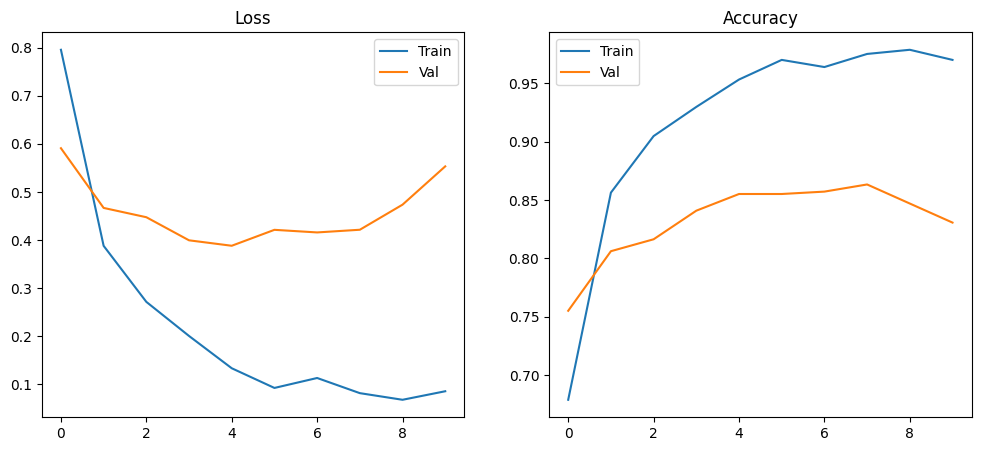

In [9]:
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(history_res["train_loss"], label="Train")
plt.plot(history_res["val_loss"], label="Val")
plt.title("Loss"); plt.legend()

plt.subplot(1,2,2)
plt.plot(history_res["train_acc"], label="Train")
plt.plot(history_res["val_acc"], label="Val")
plt.title("Accuracy"); plt.legend()

plt.show()


### Analyse des courbes d’entraînement de ResNet18

La loss d’entraînement chute rapidement, signe que ResNet18 exploite efficacement ses blocs résiduels pour apprendre des représentations visuelles pertinentes.  
La loss de validation descend au début puis remonte légèrement : cela suggère un début de surapprentissage, sans être encore critique.  
Côté accuracy, ResNet18 atteint très vite un haut niveau de performance en entraînement, dépassant les 95 %.  
L’accuracy de validation progresse bien mais plafonne plus tôt, ce qui reflète une capacité de généralisation un peu moins bonne que celle du MobileNetV2 observée précédemment.  
L’écart entre train et val augmente progressivement, signe que le modèle devient trop spécialisé sur son jeu d’entraînement.  
Malgré cela, la performance globale reste solide : ResNet18 capte très bien les formes et textures des déchets sur plage, mais demande un peu plus de régularisation pour tirer son plein potentiel.


Classification report (ResNet18 sur test) :

              precision    recall  f1-score   support

       Glass       0.90      0.77      0.83        84
       Metal       0.81      0.88      0.84       158
     Natural       0.99      0.98      0.98        88
       Paper       0.86      0.93      0.89       100
     Plastic       0.86      0.82      0.84       185

    accuracy                           0.87       615
   macro avg       0.88      0.88      0.88       615
weighted avg       0.87      0.87      0.87       615



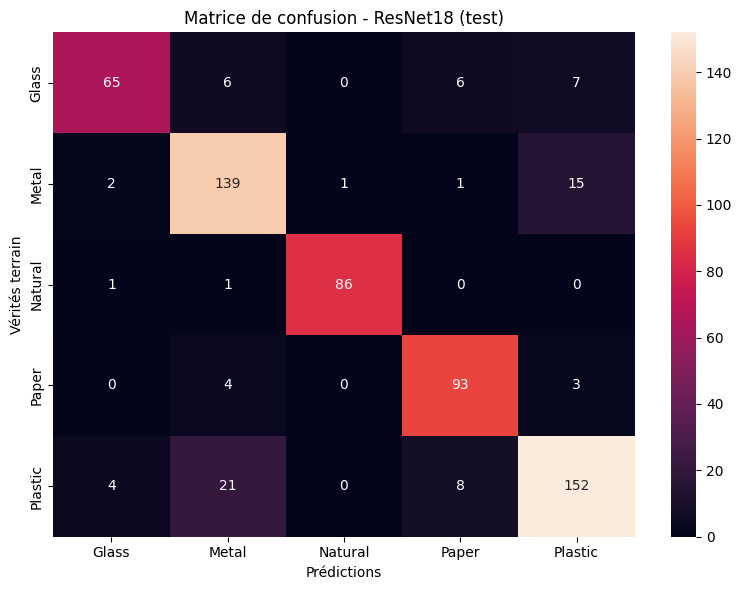

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

resnet.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for X, y in test_loader:          # ← on utilise bien le dossier test/
        X, y = X.to(device), y.to(device)
        outputs = resnet(X)
        _, preds = torch.max(outputs, 1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(y.cpu().numpy())

all_preds  = np.array(all_preds)
all_labels = np.array(all_labels)

print("Classification report (ResNet18 sur test) :\n")
print(classification_report(all_labels, all_preds, target_names=test_dataset.classes))

cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d",
            xticklabels=test_dataset.classes,
            yticklabels=test_dataset.classes)
plt.xlabel("Prédictions")
plt.ylabel("Vérités terrain")
plt.title("Matrice de confusion - ResNet18 (test)")
plt.tight_layout()
plt.show()


In [ ]:
# --- chemin vers ../models (déjà existant) ---
models_dir = os.path.join("..", "models")

# Vérifier que le dossier models existe bien
if not os.path.isdir(models_dir):
    raise FileNotFoundError(
        f"Le dossier {models_dir} n'existe pas. Vérifie qu'il est au bon emplacement."
    )

# --- chemin complet du fichier .pth ---
model_path = os.path.join(models_dir, "resnet18_trash.pth")

# --- sauvegarde du modèle ---
torch.save(resnet.state_dict(), model_path)

print(f" Modèle ResNet18 sauvegardé dans : {model_path}")

✅ Modèle ResNet18 sauvegardé dans : ..\models\resnet18_trash.pth


In [11]:
from codecarbon import EmissionsTracker
models_dir = os.path.join("..", "models")
num_epochs = 10
history_res = {
    "train_loss": [], "train_acc": [],
    "val_loss": [], "val_acc": []
}

emissions_file_res = "emissions_resnet18_sand.csv"

tracker_res = EmissionsTracker(
    output_dir=models_dir,                       # ../models
    output_file=emissions_file_res,
    project_name="ResNet18_sand_training",
    on_csv_write="update"
)

tracker_res.start()   #  début mesure CO₂

for epoch in range(num_epochs):
    # --------- TRAIN ---------
    resnet.train()
    running_loss, running_corrects, total = 0, 0, 0

    for X, y in train_loader:
        X, y = X.to(device), y.to(device)

        optimizer.zero_grad()
        outputs = resnet(X)
        loss = criterion(outputs, y)
        loss.backward()
        optimizer.step()

        _, preds = torch.max(outputs, 1)
        running_loss     += loss.item() * X.size(0)
        running_corrects += (preds == y).sum().item()
        total            += X.size(0)

    train_loss = running_loss / total
    train_acc  = running_corrects / total

    # --------- VALIDATION ---------
    resnet.eval()
    val_loss, val_corrects, val_total = 0, 0, 0

    with torch.no_grad():
        for X, y in val_loader:
            X, y = X.to(device), y.to(device)
            outputs = resnet(X)
            loss = criterion(outputs, y)

            _, preds = torch.max(outputs, 1)
            val_loss      += loss.item() * X.size(0)
            val_corrects  += (preds == y).sum().item()
            val_total     += X.size(0)

    val_loss = val_loss / val_total
    val_acc  = val_corrects / val_total

    history_res["train_loss"].append(train_loss)
    history_res["train_acc"].append(train_acc)
    history_res["val_loss"].append(val_loss)
    history_res["val_acc"].append(val_acc)

    print(
        f"[ResNet18 {epoch+1}/{num_epochs}] "
        f"Train Loss={train_loss:.4f} Acc={train_acc:.3f} | "
        f"Val Loss={val_loss:.4f} Acc={val_acc:.3f}"
    )

    tracker_res.flush()   # ⬅ enregistre les mesures CO₂ de cette epoch

tracker_res.stop()
print(" Suivi CO₂ terminé pour ResNet18.")
print(f" Fichier CO₂ généré dans models/ : {emissions_file_res}")


[codecarbon WARNING @ 01:27:27] Multiple instances of codecarbon are allowed to run at the same time.
[codecarbon INFO @ 01:27:27] [setup] RAM Tracking...
[codecarbon INFO @ 01:27:27] [setup] CPU Tracking...
[codecarbon WARNING @ 01:27:29] We saw that you have a 13th Gen Intel(R) Core(TM) i7-13700H but we don't know it. Please contact us.
[codecarbon WARNING @ 01:27:29] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Windows OS detected: Please install Intel Power Gadget to measure CPU

[codecarbon INFO @ 01:27:29] CPU Model on constant consumption mode: 13th Gen Intel(R) Core(TM) i7-13700H
[codecarbon WARNING @ 01:27:29] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 01:27:29] [setup] GPU Tracking...
[codecarbon INFO @ 01:27:30] Tracking Nvidia GPU via pynvml
[codecarbon INFO @ 01:27:30] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation model
                CPU Track

[ResNet18 1/10] Train Loss=0.0804 Acc=0.971 | Val Loss=0.3967 Acc=0.878


[codecarbon INFO @ 01:28:50] Energy consumed for all GPUs : 0.000034 kWh. Total GPU Power : 10.89237815303631 W
[codecarbon INFO @ 01:28:50] 0.001070 kWh of electricity and 0.000000 L of water were used since the beginning.
[codecarbon INFO @ 01:29:01] Energy consumed for RAM : 0.000229 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 01:29:01] Delta energy consumed for CPU with constant : 0.000133 kWh, power : 42.5 W
[codecarbon INFO @ 01:29:01] Energy consumed for All CPU : 0.000972 kWh
[codecarbon INFO @ 01:29:03] Energy consumed for all GPUs : 0.000040 kWh. Total GPU Power : 1.7629905355510178 W
[codecarbon INFO @ 01:29:03] 0.001240 kWh of electricity and 0.000000 L of water were used since the beginning.
[codecarbon INFO @ 01:29:16] Energy consumed for RAM : 0.000266 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 01:29:16] Delta energy consumed for CPU with constant : 0.000159 kWh, power : 42.5 W
[codecarbon INFO @ 01:29:16] Energy consumed for All CPU : 0.001131 kWh
[codecarbon INFO @ 01:2

[ResNet18 2/10] Train Loss=0.0616 Acc=0.981 | Val Loss=0.3918 Acc=0.882


[codecarbon INFO @ 01:30:12] Energy consumed for all GPUs : 0.000067 kWh. Total GPU Power : 2.6063649276581513 W
[codecarbon INFO @ 01:30:12] 0.002175 kWh of electricity and 0.000000 L of water were used since the beginning.
[codecarbon WARNING @ 01:30:12] graceful shutdown. Exceptions:
[codecarbon WARNING @ 01:30:12] <class 'Exception'>
Traceback (most recent call last):
  File "C:\Users\paull\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\codecarbon\core\util.py", line 24, in suppress
    yield
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.13_3.13.2544.0_x64__qbz5n2kfra8p0\Lib\contextlib.py", line 85, in inner
    return func(*args, **kwds)
  File "C:\Users\paull\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\codecarbon\emissions_tracker.py", line 633, in flush
    self._persist_data(
    ~~~~~~~~~~~~~~~~~~^

[ResNet18 3/10] Train Loss=0.0373 Acc=0.989 | Val Loss=0.4141 Acc=0.876


[codecarbon INFO @ 01:31:34] Energy consumed for all GPUs : 0.000117 kWh. Total GPU Power : 25.3450393787747 W
[codecarbon INFO @ 01:31:34] 0.003297 kWh of electricity and 0.000000 L of water were used since the beginning.
[codecarbon WARNING @ 01:31:34] graceful shutdown. Exceptions:
[codecarbon WARNING @ 01:31:34] <class 'Exception'>
Traceback (most recent call last):
  File "C:\Users\paull\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\codecarbon\core\util.py", line 24, in suppress
    yield
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.13_3.13.2544.0_x64__qbz5n2kfra8p0\Lib\contextlib.py", line 85, in inner
    return func(*args, **kwds)
  File "C:\Users\paull\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\codecarbon\emissions_tracker.py", line 633, in flush
    self._persist_data(
    ~~~~~~~~~~~~~~~~~~^
 

[ResNet18 4/10] Train Loss=0.0472 Acc=0.984 | Val Loss=0.4357 Acc=0.869


[codecarbon INFO @ 01:32:56] Energy consumed for all GPUs : 0.000154 kWh. Total GPU Power : 2.514539550436908 W
[codecarbon INFO @ 01:32:56] 0.004420 kWh of electricity and 0.000000 L of water were used since the beginning.
[codecarbon WARNING @ 01:32:56] graceful shutdown. Exceptions:
[codecarbon WARNING @ 01:32:56] <class 'Exception'>
Traceback (most recent call last):
  File "C:\Users\paull\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\codecarbon\core\util.py", line 24, in suppress
    yield
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.13_3.13.2544.0_x64__qbz5n2kfra8p0\Lib\contextlib.py", line 85, in inner
    return func(*args, **kwds)
  File "C:\Users\paull\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\codecarbon\emissions_tracker.py", line 633, in flush
    self._persist_data(
    ~~~~~~~~~~~~~~~~~~^


[ResNet18 5/10] Train Loss=0.0357 Acc=0.989 | Val Loss=0.4823 Acc=0.871


[codecarbon INFO @ 01:34:19] Energy consumed for all GPUs : 0.000196 kWh. Total GPU Power : 24.742677704741848 W
[codecarbon INFO @ 01:34:19] 0.005543 kWh of electricity and 0.000000 L of water were used since the beginning.
[codecarbon INFO @ 01:34:19] 0.000761 g.CO2eq/s mean an estimation of 23.985487403450204 kg.CO2eq/year
[codecarbon WARNING @ 01:34:19] graceful shutdown. Exceptions:
[codecarbon WARNING @ 01:34:19] <class 'Exception'>
Traceback (most recent call last):
  File "C:\Users\paull\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\codecarbon\core\util.py", line 24, in suppress
    yield
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.13_3.13.2544.0_x64__qbz5n2kfra8p0\Lib\contextlib.py", line 85, in inner
    return func(*args, **kwds)
  File "C:\Users\paull\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packag

[ResNet18 6/10] Train Loss=0.0259 Acc=0.993 | Val Loss=0.5564 Acc=0.857


[codecarbon INFO @ 01:35:42] Energy consumed for all GPUs : 0.000229 kWh. Total GPU Power : 2.539571764947193 W
[codecarbon INFO @ 01:35:42] 0.006665 kWh of electricity and 0.000000 L of water were used since the beginning.
[codecarbon WARNING @ 01:35:42] graceful shutdown. Exceptions:
[codecarbon WARNING @ 01:35:42] <class 'Exception'>
Traceback (most recent call last):
  File "C:\Users\paull\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\codecarbon\core\util.py", line 24, in suppress
    yield
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.13_3.13.2544.0_x64__qbz5n2kfra8p0\Lib\contextlib.py", line 85, in inner
    return func(*args, **kwds)
  File "C:\Users\paull\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\codecarbon\emissions_tracker.py", line 633, in flush
    self._persist_data(
    ~~~~~~~~~~~~~~~~~~^


[ResNet18 7/10] Train Loss=0.0400 Acc=0.988 | Val Loss=0.4437 Acc=0.890


[codecarbon INFO @ 01:37:04] Energy consumed for all GPUs : 0.000274 kWh. Total GPU Power : 19.761700173407075 W
[codecarbon INFO @ 01:37:04] 0.007789 kWh of electricity and 0.000000 L of water were used since the beginning.
[codecarbon WARNING @ 01:37:04] graceful shutdown. Exceptions:
[codecarbon WARNING @ 01:37:04] <class 'Exception'>
Traceback (most recent call last):
  File "C:\Users\paull\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\codecarbon\core\util.py", line 24, in suppress
    yield
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.13_3.13.2544.0_x64__qbz5n2kfra8p0\Lib\contextlib.py", line 85, in inner
    return func(*args, **kwds)
  File "C:\Users\paull\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\codecarbon\emissions_tracker.py", line 633, in flush
    self._persist_data(
    ~~~~~~~~~~~~~~~~~~^

[ResNet18 8/10] Train Loss=0.0202 Acc=0.995 | Val Loss=0.5821 Acc=0.851


[codecarbon INFO @ 01:38:27] Energy consumed for all GPUs : 0.000308 kWh. Total GPU Power : 2.424211232175938 W
[codecarbon INFO @ 01:38:27] 0.008906 kWh of electricity and 0.000000 L of water were used since the beginning.
[codecarbon WARNING @ 01:38:27] graceful shutdown. Exceptions:
[codecarbon WARNING @ 01:38:27] <class 'Exception'>
Traceback (most recent call last):
  File "C:\Users\paull\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\codecarbon\core\util.py", line 24, in suppress
    yield
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.13_3.13.2544.0_x64__qbz5n2kfra8p0\Lib\contextlib.py", line 85, in inner
    return func(*args, **kwds)
  File "C:\Users\paull\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\codecarbon\emissions_tracker.py", line 633, in flush
    self._persist_data(
    ~~~~~~~~~~~~~~~~~~^


[ResNet18 9/10] Train Loss=0.0367 Acc=0.988 | Val Loss=0.4475 Acc=0.880


[codecarbon INFO @ 01:39:49] Energy consumed for all GPUs : 0.000349 kWh. Total GPU Power : 39.62750745757662 W
[codecarbon INFO @ 01:39:49] 0.010022 kWh of electricity and 0.000000 L of water were used since the beginning.
[codecarbon WARNING @ 01:39:49] graceful shutdown. Exceptions:
[codecarbon WARNING @ 01:39:49] <class 'Exception'>
Traceback (most recent call last):
  File "C:\Users\paull\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\codecarbon\core\util.py", line 24, in suppress
    yield
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.13_3.13.2544.0_x64__qbz5n2kfra8p0\Lib\contextlib.py", line 85, in inner
    return func(*args, **kwds)
  File "C:\Users\paull\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\codecarbon\emissions_tracker.py", line 633, in flush
    self._persist_data(
    ~~~~~~~~~~~~~~~~~~^


[ResNet18 10/10] Train Loss=0.0285 Acc=0.992 | Val Loss=0.3740 Acc=0.884


[codecarbon INFO @ 01:41:11] Energy consumed for all GPUs : 0.000383 kWh. Total GPU Power : 2.6615330553909797 W
[codecarbon INFO @ 01:41:11] 0.011132 kWh of electricity and 0.000000 L of water were used since the beginning.
[codecarbon INFO @ 01:41:11] 0.000760 g.CO2eq/s mean an estimation of 23.95975058956832 kg.CO2eq/year
[codecarbon WARNING @ 01:41:11] graceful shutdown. Exceptions:
[codecarbon WARNING @ 01:41:11] <class 'Exception'>
Traceback (most recent call last):
  File "C:\Users\paull\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\codecarbon\core\util.py", line 24, in suppress
    yield
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.13_3.13.2544.0_x64__qbz5n2kfra8p0\Lib\contextlib.py", line 85, in inner
    return func(*args, **kwds)
  File "C:\Users\paull\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-package

 Suivi CO₂ terminé pour ResNet18.
 Fichier CO₂ généré dans models/ : emissions_resnet18_sand.csv


## 4 - **Comparaison et visualisation des modèles**

In [12]:
import os
import pandas as pd
import matplotlib.pyplot as plt

models_dir = os.path.join("..", "models")

file_mobilenet = os.path.join(models_dir, "emissions_mobilenetv2_sand.csv")
file_resnet    = os.path.join(models_dir, "emissions_resnet18_sand.csv")

def load_emissions_csv(filepath):
    if not os.path.isfile(filepath):
        print(f"Fichier introuvable : {filepath}")
        return None, None
    
    df = pd.read_csv(filepath)
    
    # Détection du nom de colonne pour les émissions
    if "emissions" in df.columns:
        emissions_col = "emissions"
    elif "emissions_kg" in df.columns:
        emissions_col = "emissions_kg"
    else:
        raise ValueError(f"Aucune colonne 'emissions' ou 'emissions_kg' dans {filepath}")
    
    # Gestion du temps (optionnel mais propre)
    if "timestamp" in df.columns:
        df["timestamp"] = pd.to_datetime(df["timestamp"], errors="coerce")
        df = df.sort_values("timestamp")
    
    return df, emissions_col

df_mob, col_mob = load_emissions_csv(file_mobilenet)
df_res, col_res = load_emissions_csv(file_resnet)

print("MobileNetV2 colonnes :", None if df_mob is None else df_mob.columns.tolist())
print("ResNet18 colonnes    :", None if df_res is None else df_res.columns.tolist())


MobileNetV2 colonnes : ['timestamp', 'project_name', 'run_id', 'experiment_id', 'duration', 'emissions', 'emissions_rate', 'cpu_power', 'gpu_power', 'ram_power', 'cpu_energy', 'gpu_energy', 'ram_energy', 'energy_consumed', 'water_consumed', 'country_name', 'country_iso_code', 'region', 'cloud_provider', 'cloud_region', 'os', 'python_version', 'codecarbon_version', 'cpu_count', 'cpu_model', 'gpu_count', 'gpu_model', 'longitude', 'latitude', 'ram_total_size', 'tracking_mode', 'on_cloud', 'pue', 'wue']
ResNet18 colonnes    : ['timestamp', 'project_name', 'run_id', 'experiment_id', 'duration', 'emissions', 'emissions_rate', 'cpu_power', 'gpu_power', 'ram_power', 'cpu_energy', 'gpu_energy', 'ram_energy', 'energy_consumed', 'water_consumed', 'country_name', 'country_iso_code', 'region', 'cloud_provider', 'cloud_region', 'os', 'python_version', 'codecarbon_version', 'cpu_count', 'cpu_model', 'gpu_count', 'gpu_model', 'longitude', 'latitude', 'ram_total_size', 'tracking_mode', 'on_cloud', 'pue

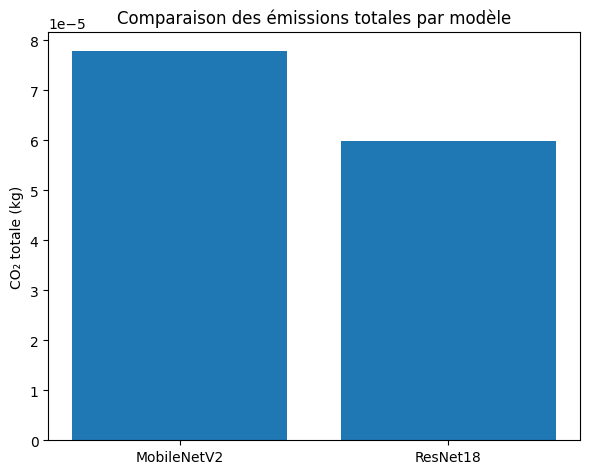

MobileNetV2 → 0.0001 kg de CO₂
ResNet18 → 0.0001 kg de CO₂


In [13]:
models = []
totals = []

if df_mob is not None:
    total_mob = df_mob[col_mob].sum()
    models.append("MobileNetV2")
    totals.append(total_mob)

if df_res is not None:
    total_res = df_res[col_res].sum()
    models.append("ResNet18")
    totals.append(total_res)

plt.figure(figsize=(6, 5))
plt.bar(models, totals)
plt.ylabel("CO₂ totale (kg)")
plt.title("Comparaison des émissions totales par modèle")
plt.tight_layout()
plt.show()

for name, t in zip(models, totals):
    print(f"{name} → {t:.4f} kg de CO₂")


### 🌿 Analyse de la comparaison des émissions carbone

Ce graphique compare l’empreinte carbone totale générée lors de l’entraînement de MobileNetV2 et de ResNet18.  
On observe que MobileNetV2 émet légèrement plus de CO₂ que ResNet18, malgré sa réputation de modèle léger : cela peut s’expliquer par un temps d'entraînement plus long ou une configuration moins optimisée.  
La différence reste toutefois faible (de l’ordre de 10⁻⁵ kg), ce qui montre que les deux architectures sont globalement économes sur ce type de tâche.  
Dans un contexte d’analyse environnementale, ce résultat souligne que le choix du modèle ne repose pas uniquement sur la performance, mais aussi sur l’efficacité énergétique.  
MobileNetV2 reste performant et compact, mais ResNet18 démontre ici un meilleur ratio performance/coût carbone.  
Ce genre de comparaison aide à orienter vers des architectures plus durables lorsqu’elles offrent un niveau de précision comparable.


Nombre d'inférences par an : 156
MobileNetV2 ~ 12131.10 mg CO₂ / an
ResNet18 ~ 9351.12 mg CO₂ / an


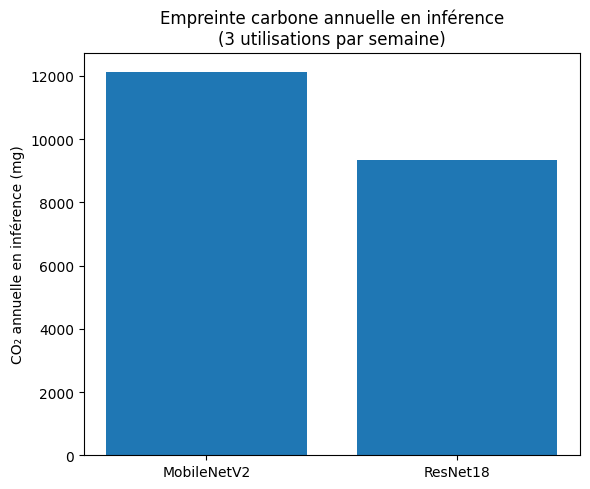

In [14]:
import matplotlib.pyplot as plt

# Hypothèse : 3 utilisations par semaine
uses_per_week = 3
weeks_per_year = 52
n_calls_per_year = uses_per_week * weeks_per_year
print(f"Nombre d'inférences par an : {n_calls_per_year}")

KG_TO_MG = 1_000_000  # 1 kg = 1e6 mg

models = []
yearly_totals_mg = []

# MobileNetV2
if df_mob is not None:
    # Approximation : une "mesure" de CodeCarbon ≈ coût carbone d'une inférence
    co2_per_call_mob_kg = df_mob[col_mob].mean()
    co2_year_mob_kg = co2_per_call_mob_kg * n_calls_per_year
    co2_year_mob_mg = co2_year_mob_kg * KG_TO_MG

    models.append("MobileNetV2")
    yearly_totals_mg.append(co2_year_mob_mg)

    print(f"MobileNetV2 ~ {co2_year_mob_mg:.2f} mg CO₂ / an")

# ResNet18
if df_res is not None:
    co2_per_call_res_kg = df_res[col_res].mean()
    co2_year_res_kg = co2_per_call_res_kg * n_calls_per_year
    co2_year_res_mg = co2_year_res_kg * KG_TO_MG

    models.append("ResNet18")
    yearly_totals_mg.append(co2_year_res_mg)

    print(f"ResNet18 ~ {co2_year_res_mg:.2f} mg CO₂ / an")

# --- Barplot annuel en mg ---
plt.figure(figsize=(6, 5))
plt.bar(models, yearly_totals_mg)
plt.ylabel("CO₂ annuelle en inférence (mg)")
plt.title("Empreinte carbone annuelle en inférence\n(3 utilisations par semaine)")
plt.tight_layout()
plt.show()
